# <span style="font-family:times; font-size:1.5em;"> <b>LipReaderAI: Lip-reading Machine Learning Model

<span style="font-family:times; font-size:1.3em;">  Working in the LiveLipNet-env, for setting-up the environment and other python scripts, data and the saved checkpoints refer to - https://github.com/33ron33/LipReaderAI

<span style="font-family:times; font-size:1.3em;"> Checking the installed libraries in the environment.

In [1]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
aiobotocore                   2.7.0
aiohttp                       3.9.0
aioitertools                  0.7.1
aiosignal                     1.2.0
alabaster                     0.7.12
altair                        5.3.0
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.4
anaconda-navigator            2.5.0
anaconda-project              0.11.1
anyio                         3.5.0
apache-beam                   2.55.1
appdirs                       1.4.4
archspec                      0.2.1
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
array_record                  0.5.1
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.3.4
asttokens                     2.0.5
astunparse                    1.6.3
async-lru

<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Importing the libraries used in the code.
</span>
</div>

<span style="font-family:times; font-size:1.3em;"> This cell imports the required libraries for the project, including libraries for file handling, computer vision, numerical operations, plotting, and machine learning. TensorFlow and its related components are imported to build and train the machine learning model.

In [3]:
import os # For opening and connnecting paths to the files
import cv2 # For computer Vision that is for image or video processing
import tensorflow as tf # For model training in Machine Learning
import numpy as np # For Numerical Operations
from matplotlib import pyplot as plt # For Plotting images (frames) and functions
import imageio # For converting the images to gifs
from typing import List
import json
# Tensorflow Model Libraries.
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential # Represents the sequence of layers of the model.

# Components of the layered model architecture
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, TimeDistributed, Flatten 
from tensorflow.keras.optimizers import Adam # importing the optimizer for the model.

 # For saving the trained weights and for changing the lerning rate during training.  
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler 

<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Checking for the GPU availability.
</span>
</div>


In [5]:
# Checks for the GPU
!nvidia-smi
if len(tf.config.list_physical_devices('GPU'))>0:
    print( 'GPU is available!',tf.config.list_physical_devices('GPU'))
else:
    print("No GPU is available")

No devices were found
No GPU is available


<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Defining our english letters and numbers that the model may encounter.
</span>
</div>

<span style="font-family:times; font-size:1.3em;"> This cell sets up the vocabulary for the model, which includes all letters, punctuation, and digits the model may encounter. It then creates mappings to convert letters to numbers and vice versa, which are essential for processing and interpreting text data.

In [6]:
''' Loading the subtitles that are enocded in the .align files, but before that we need to describe our words and letters that the model may encounter-
and writing a code segment that can convert the numbers to the chararcters and the vice versa of it '''

vocab = "abcdefghijklmnopqrstuvwxyz'?!123456789"
# Mapping the english letters to numbers
letter_to_number = tf.keras.layers.StringLookup(vocabulary=list(vocab), oov_token="")
 # Mapping the numbers to letters-
numbers_to_letters = tf.keras.layers.StringLookup(vocabulary=letter_to_number.get_vocabulary(), oov_token="", invert=True)

In [7]:
print(f"The vocabulary is: {letter_to_number.get_vocabulary()} "f"(size ={letter_to_number.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [8]:
letter_to_number(['r','o','h','a','n'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([18, 15,  8,  1, 14])>

In [9]:
numbers_to_letters([18, 15,  8,  1, 14])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'r', b'o', b'h', b'a', b'n'], dtype=object)>

<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Importing and Pre-processing the GRID-dataset.
</span>
</div>

<span style="font-family:times; font-size:1.3em;"> This function imports video and subtitle alignment data given a base path. It includes two helper functions: import_video to load and preprocess the video frames, and import_subtitles to load and convert subtitle alignments to numerical indices using the previously defined character-to-number mapping.

In [10]:
def grid_data_import(path: str): # -> Tuple[tf.Tensor, tf.Tensor]: This function imports the video and subtitle alignment data given the base path.
    

    def import_video(path: str) -> tf.Tensor:  # This function imports the video
        
        cap = cv2.VideoCapture(path) # Load the video
        frames = [] # Create an empty list to store the frames
        while True: # Loop through all the frames
            ret, frame = cap.read() # Read the frame
            if not ret: # If the frame is not read, break the loop
                break 
            frame = tf.image.rgb_to_grayscale(frame) # Convert the frame to grayscale
            frames.append(frame[180:250, 80:220, :]) # Crop the frame and append it to the list
        cap.release() # Release the video
        frames = tf.convert_to_tensor(frames, dtype=tf.float32) # Convert the list to a tensor
        mean = tf.math.reduce_mean(frames) # Calculate the mean of the frames so that we can normalize them
        std = tf.math.reduce_std(frames)    # Calculate the standard deviation of the frames
        return (frames - mean) / std # Normalize the frames and return them

    def import_subtitles(path: str) -> tf.Tensor:   # This function imports the subtitle alignment data
        """Import subtitle alignment data, convert them to indices using character to number conversion."""
        with open(path, 'r') as f: # Open the file
            lines = f.readlines() # Read the lines
        tokens = [] # Create an empty list to store the tokens
        for line in lines: # Loop through the lines
            parts = line.strip().split() # Split the line
            if parts[2] != 'sil':   # If the token is not a silence token
                tokens.extend([' ', parts[2]])  # Append the token to the list
        tokens = ''.join(tokens) # Join the tokens
        return letter_to_number(tf.strings.unicode_split(tokens, 'UTF-8')) # Convert the tokens to numbers

    
    # Check if input is a TensorFlow tensor and convert to Python string if so
    '''I have added this to make this complatible for both the calls for a string or a tensor'''
    if isinstance(path, tf.Tensor):
        path = path.numpy().decode('utf-8')
    else:
        path = path
        
    file_name = os.path.splitext(os.path.basename(path))[0] # Get the file name
    video_path = os.path.join('data', 'sv', f'{file_name}.mpg') # Get the video path
    alignment_path = os.path.join('data', 'salignments', f'{file_name}.align') # Get the alignment path

    frames = import_video(video_path) # Import the video
    alignments = import_subtitles(alignment_path)    # Import the alignments 
    return frames, alignments


<div class='alert alert-success'> <span style="font-family:times; font-size:1.5em;"> Checking the functioning of the above defined grid_data_import function for a sample path.
</span>
</div>

<span style="font-family:times; font-size:1.3em;"> This cell tests the grid_data_import function for a specific video file and plots a frame to visualize lip movements. It displays frame 33 from the video, showing lip movements in grayscale, and saves the figure as "speaker_34.png".

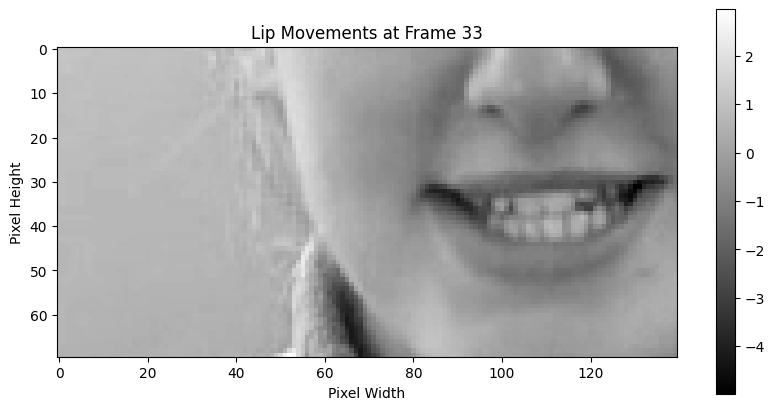

<Figure size 640x480 with 0 Axes>

In [11]:
# Test the functionality for a specific video
test_path = 'data/sv/sbad5n.mpg'
frames, alignments = grid_data_import(test_path)

# Plot a specific frame to visualize lip movements
plt.figure(figsize=(10, 5))  # Set the figure size for better visibility
plt.imshow(frames[33], cmap='gray')  # Use grayscale color map for better visual of lip movements
plt.colorbar()  # Optionally add a colorbar to illustrate pixel intensity scale
plt.title('Lip Movements at Frame 33')  # Title of the plot
plt.xlabel('Pixel Width')  # X-axis label
plt.ylabel('Pixel Height')  # Y-axis label
plt.show()
plt.savefig('speaker_34.png')  # Save the figure as "speaker_34.png"

<tf.Tensor: shape=(28,), dtype=int64, numpy=
array([39,  2,  9, 14, 39, 23,  8,  9, 20,  5, 39,  2, 25, 39,  5, 39, 19,
        5, 22,  5, 14, 39, 16, 12,  5,  1, 19,  5])>

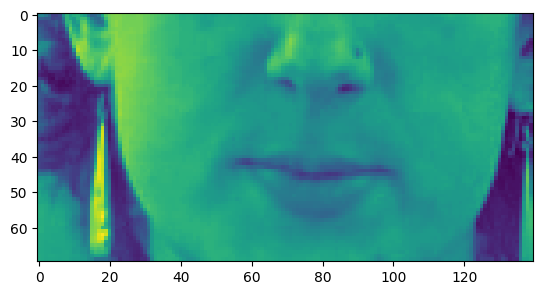

In [12]:
# Test the functionality for s24-
test_path = 'data/sv/bwbe7p.mpg'
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([39, 12,  1, 25, 39,  2, 12, 21,  5, 39,  2, 25, 39, 21, 39,  5,  9,
        7,  8, 20, 39, 14, 15, 23])>

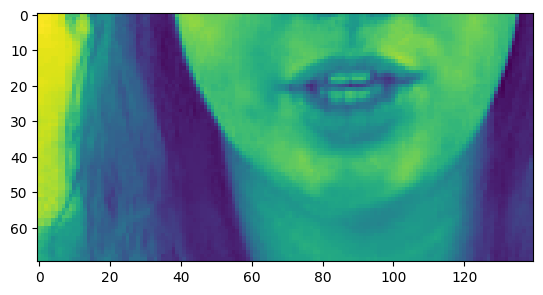

In [13]:
# Test the functionality for s25-
test_path = 'data/sv/lbbu8n.mpg'
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([39, 12,  1, 25, 39,  2, 12, 21,  5, 39,  2, 25, 39, 21, 39,  5,  9,
        7,  8, 20, 39, 19, 15, 15, 14])>

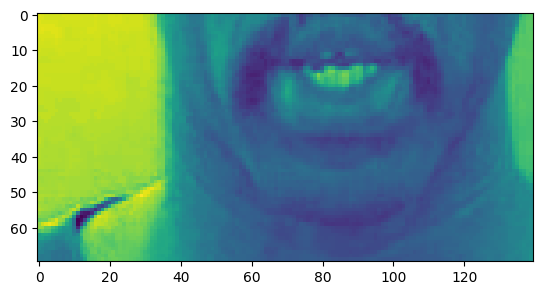

In [14]:
# Test the functionality for s26-
test_path = 'data/sv/lbbu8s.mpg'
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([39, 12,  1, 25, 39,  2, 12, 21,  5, 39,  2, 25, 39, 21, 39, 14,  9,
       14,  5, 39,  1,  7,  1,  9, 14])>

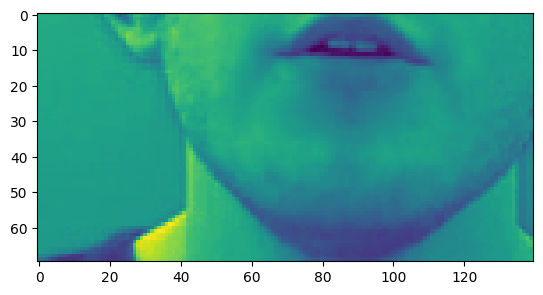

In [15]:
# Test the functionality for s27-
test_path = 'data/sv/lbbu9a.mpg'
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

<tf.Tensor: shape=(26,), dtype=int64, numpy=
array([39, 12,  1, 25, 39,  2, 12, 21,  5, 39,  2, 25, 39, 21, 39,  5,  9,
        7,  8, 20, 39,  1,  7,  1,  9, 14])>

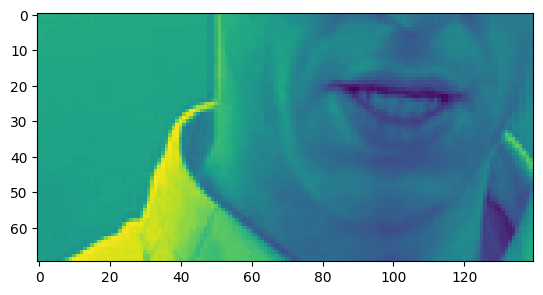

In [16]:
# Test the functionality for s28-
test_path = 'data/sv/lbbu8a.mpg'
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([39, 12,  1, 25, 39,  7, 18,  5,  5, 14, 39,  9, 14, 39, 16, 39, 15,
       14,  5, 39, 19, 15, 15, 14])>

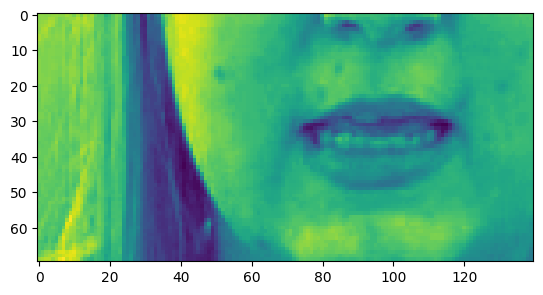

In [17]:
# Test the functionality for s29-
test_path = 'data/sv/lgip1s.mpg'
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([39,  2,  9, 14, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39, 17, 39, 19,
        9, 24, 39,  1,  7,  1,  9, 14])>

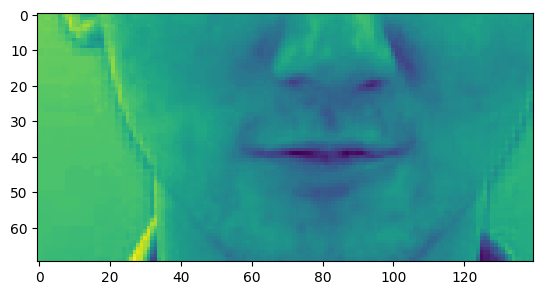

In [18]:
# Test the functionality for s30-
test_path = 'data/sv/bwaq6a.mpg'
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([39, 12,  1, 25, 39,  2, 12, 21,  5, 39,  1, 20, 39, 20, 39,  5,  9,
        7,  8, 20, 39, 14, 15, 23])>

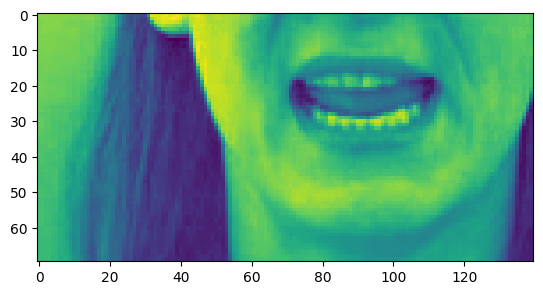

In [19]:
# Test the functionality for s31
test_path = 'data/sv/lbat8n.mpg'
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([39, 19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  2, 25, 39, 12, 39, 19,
        5, 22,  5, 14, 39, 14, 15, 23])>

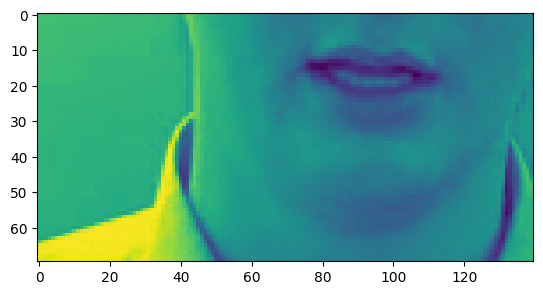

In [20]:
# Test the functionality for s32-
test_path = 'data/sv/swbl7n.mpg '
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([39, 12,  1, 25, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39,  2, 39,  5,
        9,  7,  8, 20, 39, 14, 15, 23])>

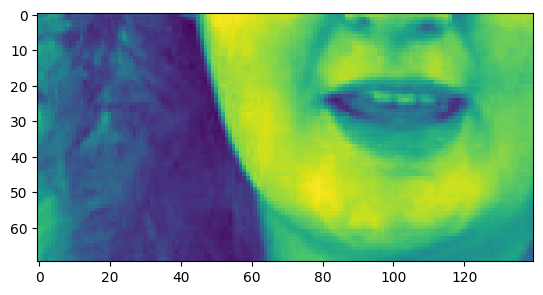

In [21]:
# Test the functionality for s33
test_path = 'data/sv/lrwb8n.mpg'
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

<tf.Tensor: shape=(23,), dtype=int64, numpy=
array([39, 19,  5, 20, 39,  2, 12, 21,  5, 39,  1, 20, 39,  4, 39,  6,  9,
       22,  5, 39, 14, 15, 23])>

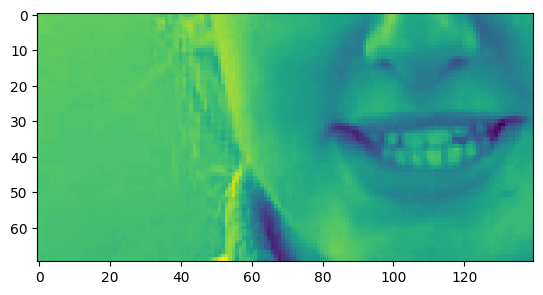

In [22]:
# Test the functionality for s34
test_path = 'data/sv/sbad5n.mpg'
frames, alignments = grid_data_import(test_path)
plt.imshow(frames[33]) # Lipmovements at this frame
alignments # Subtitles in the form of numbers

<div class='alert alert-success'> <span style="font-family:times; font-size:1.5em;"> Defining the functions seperately if need in the code.
</span>
</div> 

### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Function to Load and Preprocess Video Frames
<span style="font-family:times; font-size:1.3em;"> This function loads video frames, converts them to grayscale, normalizes them, and returns the processed frames as a TensorFlow tensor. The video is read frame by frame, converted to grayscale, cropped, and then normalized using the mean and standard deviation of the frames.

In [23]:
def load_video(path: str) -> tf.Tensor:
    """
    Load video frames, convert them to grayscale, normalize them, and return as a tensor.

    Args:
        path (str): Path to the video file.

    Returns:
        tf.Tensor: Normalized grayscale frames as a tensor.
    """
    cap = cv2.VideoCapture(path)  # Open the video file
    frames = []  # Initialize an empty list to store frames
    while True:
        ret, frame = cap.read()  # Read a frame
        if not ret:
            break  # Exit loop if no frame is read
        frame = tf.image.rgb_to_grayscale(frame)  # Convert frame to grayscale
        frames.append(frame[180:250, 80:220, :])  # Crop the frame and append to list
    cap.release()  # Release the video capture object
    frames = tf.convert_to_tensor(frames, dtype=tf.float32)  # Convert list of frames to tensor
    mean = tf.math.reduce_mean(frames)  # Calculate mean of frames
    std = tf.math.reduce_std(frames)  # Calculate standard deviation of frames
    return (frames - mean) / std  # Normalize frames and return tensor

### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Function to Load and Convert Subtitle Alignments
<span style="font-family:times; font-size:1.3em;"> This function loads subtitle alignment data from a file, processes it to extract relevant tokens, and converts these tokens to numerical indices using the previously defined character-to-number mapping.

In [24]:
def load_alignments(path: str) -> tf.Tensor:
    """
    Load alignment data, convert them to indices using character to number conversion.

    Args:
        path (str): Path to the alignment file.

    Returns:
        tf.Tensor: Numerical indices of the alignment tokens.
    """
    with open(path, 'r') as f:
        lines = f.readlines()  # Read all lines from the file
    tokens = []  # Initialize an empty list to store tokens
    for line in lines:
        parts = line.strip().split()  # Split each line into parts
        if parts[2] != 'sil':  # Skip 'sil' (silence) tokens
            tokens.extend([' ', parts[2]])  # Append tokens to the list with a preceding space
    tokens = ''.join(tokens)  # Join all tokens into a single string
    return letter_to_number(tf.strings.unicode_split(tokens, 'UTF-8'))  # Convert tokens to numerical indices

### <span style="font-family:times; font-size:1.3em;"><span style='color:orange'>  Function to Load Video and Subtitle Data
<span style="font-family:times; font-size:1.3em;"> This function combines the loading and preprocessing steps for video frames and subtitle alignments. It extracts the file name from the given path, constructs paths for the video and alignment files, and uses the helper functions load_video and load_alignments to load and preprocess the data.

In [25]:
def load_data(path: str):  # -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Load video frames and subtitle alignment data given a base path.

    Args:
        path (str): Path to the base file (excluding extensions).

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: Processed video frames and alignment indices.
    """
    path = bytes.decode(path.numpy())  # Convert the path to a string
    file_name = path.split('/')[-1].split('.')[0]  # Extract the file name without extension
    
    # Uncomment the following line if using Windows paths
    # file_name = path.split('\\')[-1].split('.')[0]
    
    video_path = os.path.join('data', 'sv', f'{file_name}.mpg')  # Construct the video file path
    alignment_path = os.path.join('data', 'salignments', f'{file_name}.align')  # Construct the alignment file path
    
    frames = load_video(video_path)  # Load and preprocess video frames
    alignments = load_alignments(alignment_path)  # Load and preprocess subtitle alignments
    
    return frames, alignments  # Return the processed data

<div class='alert alert-success'> <span style="font-family:times; font-size:1.5em;"> Converting Numerical Indices Back to Text and Checking Frame Dimensions
</span>
</div> 

<span style="font-family:times; font-size:1.3em;"> This cell converts the numerical indices back to text using the numbers_to_letters mapping and checks the shape of the frames tensor to understand its dimensions.

In [26]:
# Convert numerical indices back to text
decoded_text = tf.strings.reduce_join([bytes.decode(x) for x in numbers_to_letters(alignments.numpy()).numpy()])

# Print the decoded text
print("Decoded Text:", decoded_text.numpy().decode('utf-8'))

# Check the shape of the frames tensor
frames_shape = frames.shape
print("Frames Shape:", frames_shape)


Decoded Text:  set blue at d five now
Frames Shape: (75, 70, 140, 1)


<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Creating a DATA Pipeline

### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Creating a Dataset from Video File Paths
<span style="font-family:times; font-size:1.3em;"> This cell creates a TensorFlow dataset containing paths to .mpg video files located in the data/sv directory. The list_files function generates a dataset of file paths, and as_numpy_iterator().next() is used to retrieve the next file path from the dataset for inspection.

In [27]:
'''Creating a dataset from the paths that is theis pipeline creates a path where the data is loaded in 
                                                                               from the s1 folder and the "data" function looks for a .mpg files'''
data = tf.data.Dataset.list_files('./data/sv/*.mpg') 
data.as_numpy_iterator().next()

b'./data/sv/swaf7a.mpg'

### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Shuffling the Dataset for Training
<span style="font-family:times; font-size:1.3em;"> This cell shuffles the dataset to ensure that the model trains on different subsets of data in each iteration. It grabs the first 500 file paths and does not reshuffle the data in each iteration.

In [28]:
# Shuffling the dataset to train the model with different sets
# Grabbing the first 500 file paths and ensuring no reshuffling in each iteration
data = data.shuffle(500, reshuffle_each_iteration=False)

# Display the dataset after shuffling
data

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Defining a Mapping Function to Load Data
<span style="font-family:times; font-size:1.3em;"> This function maps file paths to the actual data (video frames and subtitle alignments) by using the load_data function. It converts the file path into the corresponding data tensors using TensorFlow's tf.py_function.

In [30]:
# Define a mapping function to load data from file paths
def mappable_function(path):  # -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Map a file path to the corresponding video frames and subtitle alignments.

    Args:
        path (str): Path to the video file.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: Loaded and processed video frames and alignment indices.
    """
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))  # Load the data using load_data function
    return result


### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Mapping File Paths to Data and Visualizing Frames
<span style="font-family:times; font-size:1.3em;"> This cell maps the file paths in the dataset to the actual video frames and subtitle alignments using the mappable_function. It retrieves a sample of frames and alignments, and then plots a specific frame to visualize the data.

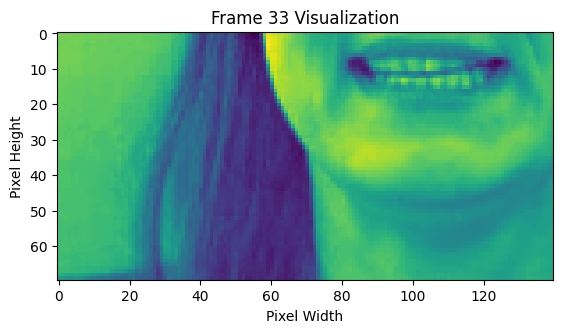

In [31]:
# Map the file paths in the dataset to the actual data using the mappable_function
data = data.map(mappable_function)

# Retrieve a sample of frames and alignments from the dataset
frames, alignments = data.as_numpy_iterator().next()

# Plot a specific frame to visualize the data
plt.imshow(frames[33])  # Display frame 33
plt.title('Frame 33 Visualization')  # Add a title for context
plt.xlabel('Pixel Width')  # Label the x-axis
plt.ylabel('Pixel Height')  # Label the y-axis
plt.show()  # Display the plot


### <span style="font-family:times; font-size:1.3em;"><span style='color:orange'>  Padding the Dataset for Batch Processing
<span style="font-family:times; font-size:1.3em;"> This cell pads the dataset to handle different lengths of alignments and frames. It uses the padded_batch function to create batches of two videos and their corresponding alignments, ensuring uniform shapes for batch processing.

In [32]:
'''We can see that the alignments are of different lenghts, so we also need to pad thedata set for alignments'''
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40])) # We will have two viodes and two alignents

In [33]:
# Checking the shape of the dataset 
for frames, alignments in data.take(1):  # Take just one batch to examine
    print("Batched frames shape:", frames.shape)  # This will show the shape of frames in one batch
    print("Batched alignments shape:", alignments.shape)  # This will show the shape of alignments in one batch


Batched frames shape: (2, 75, 70, 140, 1)
Batched alignments shape: (2, 40)


### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Prefetching the Dataset for Improved Performance
<span style="font-family:times; font-size:1.3em;"> This cell uses the prefetch method to improve the performance of the input pipeline by preloading the data. The tf.data.AUTOTUNE argument allows TensorFlow to dynamically tune the prefetch buffer size based on the system and environment.

In [34]:
# Prefetch the dataset to improve input pipeline performance
data = data.prefetch(tf.data.AUTOTUNE)

In [35]:
alignments.shape

TensorShape([2, 40])

<span style="font-family:times; font-size:1.3em;"> Length of the frames shows that two videos are batched.

In [36]:
len(frames)

2

### <span style="font-family:times; font-size:1.3em;"><span style='color:orange'> Testing the Prefetched Dataset
<span style="font-family:times; font-size:1.3em;"> This cell tests the prefetched dataset by converting it to a NumPy iterator and retrieving the next batch of frames and alignments. It then displays the frames from the first batch.

In [37]:
# Convert the prefetched dataset to a NumPy iterator
test = data.as_numpy_iterator()

# Retrieve the next batch of frames and alignments
val = test.next()

# Display the frames from the first batch
val[0]  # val[0] contains the frames

array([[[[[ 0.5552004 ],
          [ 0.5552004 ],
          [ 0.5552004 ],
          ...,
          [-0.13040777],
          [-0.13040777],
          [-0.13040777]],

         [[ 0.5552004 ],
          [ 0.5552004 ],
          [ 0.5552004 ],
          ...,
          [-0.19002587],
          [-0.19002587],
          [-0.19002587]],

         [[ 0.5552004 ],
          [ 0.5552004 ],
          [ 0.5552004 ],
          ...,
          [-0.19002587],
          [-0.19002587],
          [-0.19002587]],

         ...,

         [[ 0.37634608],
          [ 0.37634608],
          [ 0.37634608],
          ...,
          [-0.10059872],
          [-0.07078967],
          [-0.04098062]],

         [[ 0.37634608],
          [ 0.34653702],
          [ 0.31672797],
          ...,
          [-0.21983492],
          [-0.13040777],
          [-0.10059872]],

         [[ 0.25710988],
          [ 0.19749178],
          [ 0.10806463],
          ...,
          [-0.19002587],
          [-0.10059872],
          

Shape of the frames in the batch: (2, 75, 70, 140, 1)
Shape of the alignments in the batch: (2, 40)


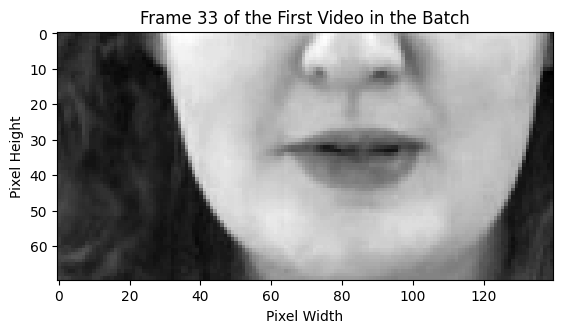

In [38]:
# Retrieve the next batch of frames and alignments
val = test.next()

# Display the frames from the first batch
print("Shape of the frames in the batch:", val[0].shape)
print("Shape of the alignments in the batch:", val[1].shape)

# Visualize the first frame of the first video in the batch
plt.imshow(val[0][0][33], cmap='gray')  # Display frame 33 of the first video
plt.title('Frame 33 of the First Video in the Batch')  # Add a title
plt.xlabel('Pixel Width')  # Label the x-axis
plt.ylabel('Pixel Height')  # Label the y-axis
plt.show()  # Display the plot


### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'>Examining and Saving a Batch of Frames as GIF
<span style="font-family:times; font-size:1.3em;"> This cell takes one batch from the dataset, examines the shape of the batched frames, selects the first video in the batch, and converts the frames to uint8 format. It then saves the frames as a GIF and displays it in the notebook.

Batched frames shape: (2, 75, 70, 140, 1)
First video frames shape: (75, 70, 140, 1)


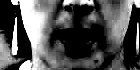

In [39]:
import imageio
from IPython.display import Image

# Take just one batch to examine
for frames, alignments in data.take(1):
    print("Batched frames shape:", frames.shape)  # Should show (2, 75, 46, 140, 1) for your batch

    # Select the first video in the batch
    first_video_frames = frames.numpy()[0]  # This will have shape (75, 46, 140, 1)
    print("First video frames shape:", first_video_frames.shape)

    # Convert frames from float32 to uint8, ensuring data is in the range 0-255
    frames_uint8 = np.clip(first_video_frames * 255, 0, 255).astype(np.uint8)

    # Reshape if necessary, check channels
    if frames_uint8.shape[-1] == 1:
        # Convert grayscale to RGB by repeating the channels
        frames_uint8 = np.repeat(frames_uint8, 3, axis=-1)

    # Save as GIF
    imageio.mimsave('./lip_movement.gif', frames_uint8, fps=10)

# Display the GIF in the notebook
Image(filename='./lip_movement.gif', width=400, height=300)


### <span style="font-family:times; font-size:1.3em;"><span style='color:orange'> Plotting a Specific Frame from the First Video in the Batch
<span style="font-family:times; font-size:1.3em;"> This cell plots the 33rd frame from the first video in the batch, providing a visual inspection of the processed video frames.

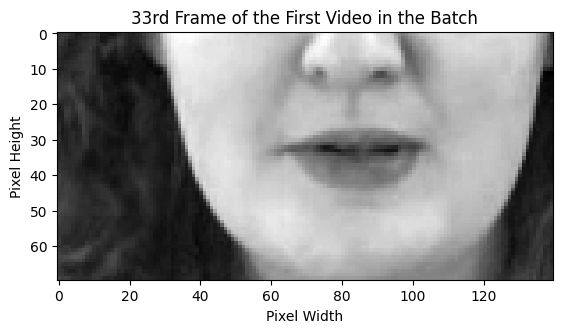

In [40]:
# 1st [0] - videos
# 2nd [0] - 1st video of the batch
# 3rd [0] - Number of the frame in the video

# Plotting the 33rd frame of the 1st video in the batch
plt.imshow(val[0][0][33], cmap='gray')  # Use grayscale color map for better visualization
plt.title('33rd Frame of the First Video in the Batch')  # Add a title for context
plt.xlabel('Pixel Width')  # Label the x-axis
plt.ylabel('Pixel Height')  # Label the y-axis
plt.show()  # Display the plot


### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Checking Shapes and Interpreting Alignments
<span style="font-family:times; font-size:1.3em;"> This section verifies the shape of the frames tensor, checks the length of the frames, confirms successful padding, and interprets the alignments using the numbers_to_letters mapping.

In [41]:
# Check the shape of the frames tensor
print("Frames shape:", frames.shape)

# Convert the dataset to a NumPy iterator and get the next sample
sample = data.as_numpy_iterator()

# Check the length of the frames tensor
print("Number of frames in the sample:", len(frames))

# Now we can see that the padding is successful
print("Alignments:", alignments)

# Interpreting the alignments using tf.strings.reduce_join
decoded_alignments = tf.strings.reduce_join([numbers_to_letters(x) for x in val[1][0]])
print("Decoded Alignments:", decoded_alignments.numpy().decode('utf-8'))


Frames shape: (2, 75, 70, 140, 1)
Number of frames in the sample: 2
Alignments: tf.Tensor(
[[39 16 12  1  3  5 39 23  8  9 20  5 39  2 25 39  9 39 26  5 18 15 39  1
   7  1  9 14  0  0  0  0  0  0  0  0  0  0  0  0]
 [39  2  9 14 39 18  5  4 39  1 20 39 24 39 15 14  5 39 16 12  5  1 19  5
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]], shape=(2, 40), dtype=int64)
Decoded Alignments:  place red with a four please


<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> Creating the Model Architecture.
</span>
</div>

<span style="font-family:times; font-size:1.5em;"> <span style='color:red'>For videos processing we are using the Conv3D and for training the model I have used the Loss function- CTC: https://keras.io/examples/audio/ctc_asr/
</span>

### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Splitting the Dataset into Training and Testing Sets
<span style="font-family:times; font-size:1.3em;"> This cell splits the dataset into training and testing sets. It calculates the sizes for both sets based on a given fraction and then uses the take and skip methods to create the training and testing datasets.

In [52]:
# Calculate the sizes of the training and testing datasets
train_size = int(0.8 * 10000)  # Adjust the fraction as needed
test_size = 10000 - train_size

# Split the dataset into training and testing sets
train = data.take(train_size)  # Training dataset
test = data.skip(train_size).take(test_size)  # Testing dataset

# Display the sizes of the training and testing datasets
print("Training dataset size:", train_size)
print("Testing dataset size:", test_size)


Training dataset size: 8000
Testing dataset size: 2000


### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Model Architecture
<span style="font-family:times; font-size:1.3em;"> This section defines the architecture of the model using the Sequential API from TensorFlow Keras. It includes convolutional layers for feature extraction, followed by bidirectional LSTM layers for sequence processing, and a dense output layer for character prediction.

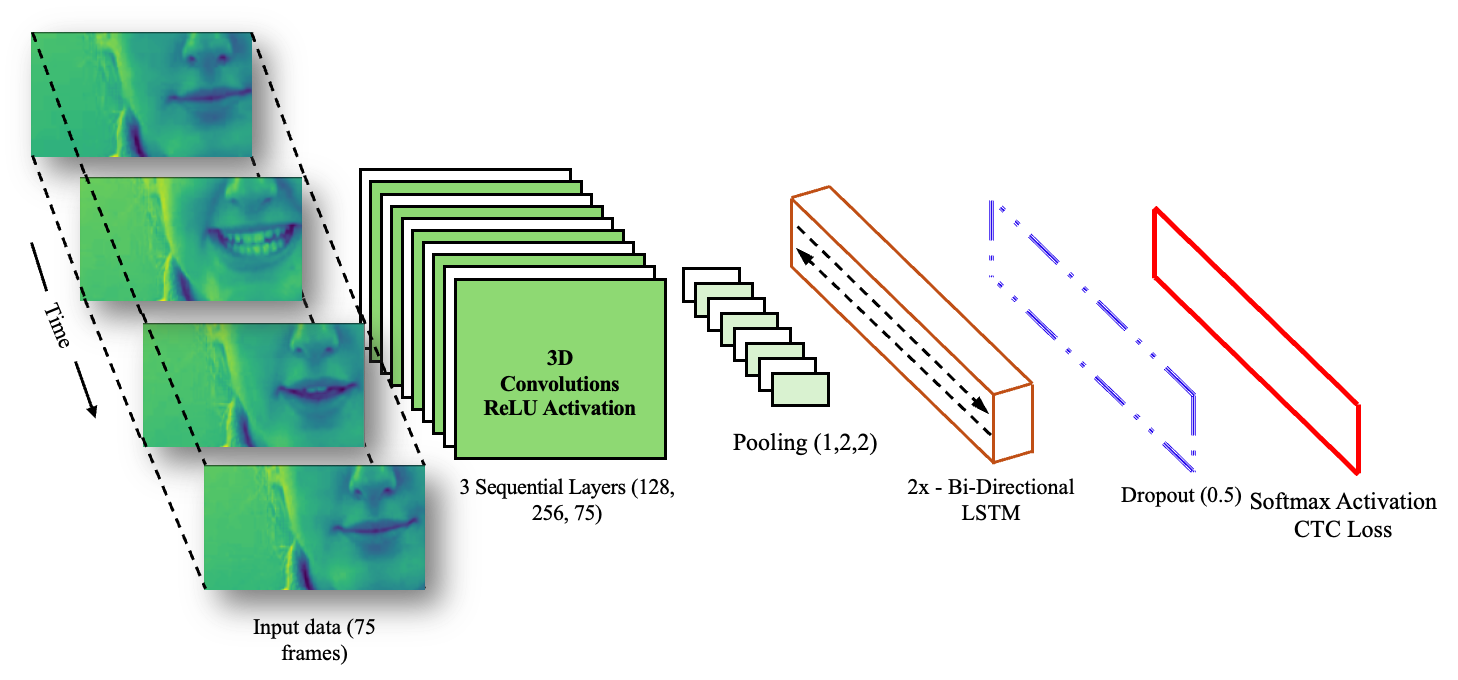

In [43]:
'''
   ---------------------------------------------------------------------- Model Architecture--------------------------------------------------------------------
'''
# Create the Sequential model
model = models.Sequential([
    
    # 3D Convolution Layer 1: This layer applies 128 filters of size (3, 3, 3) to the input data,
    layers.Conv3D(128, (3, 3, 3), padding='same', input_shape=(75, 70, 140, 1)),
    layers.Activation('relu'), # Introducing non-linearity to the model
    layers.MaxPool3D(pool_size=(1, 2, 2)),

    # 3D Convolution Layer 2: This layer applies 256 filters of size (3, 3, 3) to the input data,
    layers.Conv3D(256, (3, 3, 3), padding='same'),
    layers.Activation('relu'),
    layers.MaxPool3D(pool_size=(1, 2, 2)),

    # 3D Convolution Layer 3 : This layer applies 75 filters of size (3, 3, 3) to the input data,
    layers.Conv3D(75, (3, 3, 3), padding='same'),
    layers.Activation('relu'),
    layers.MaxPool3D(pool_size=(1, 2, 2)),

    # Flatten the output and prepare for LSTM Here from above we get the output as - (None, 75, 5, 17, 75) , then for flattening, we have preseerved the time frames and condednsed the rest to 
    #(None, 75, 5*17*75 = 6375)
    layers.TimeDistributed(Flatten()), 

    # Bidirectional LSTM Layer 1 : Bidirectional LSTM processes the sequence both forwards and backwards that is - two times (128 units) bi-directional
    layers.Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)),
    layers.Dropout(0.5),

    # Bidirectional LSTM Layer 2 : Bidirectional LSTM processes the sequence both forwards and backwards that is - two times (128 units) bi-directional
    layers.Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)),
    layers.Dropout(0.5),

    # Dense output layer gives out 75 frames and 41 characters 
    layers.Dense(letter_to_number.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax') 
])

# Summary of the model architechure
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 70, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 70, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 35, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 35, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 35, 70, 256)   0         
                                                        

<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> <b>Making a check if the model is working or not before training it!
</b>
</span>
</span>
</div>

### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Predicting and Decoding the Transcript
<span style="font-family:times; font-size:1.3em;"> This section makes predictions using the trained model, decodes the predicted alignments to character strings, and prints the decoded strings.

In [44]:
# Make predictions on the input frames
predictions = model.predict(val[0])

# Get the argmax (index of the highest probability prediction) along the last dimension (character class probabilities)
predicted_indices = tf.argmax(predictions, axis=-1)

# Convert numerical indices to character strings
decoded_characters = numbers_to_letters(predicted_indices)

# Since `decoded_characters` will be a tensor of strings, use `tf.strings.reduce_join` to concatenate the strings along the sequence
decoded_strings = tf.strings.reduce_join(decoded_characters, axis=-1)

# Print the decoded strings
print(decoded_strings.numpy())


1/1 [==============================] - 5s 5s/step
[b'!!nnnnnjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjjj111111111111111111vvvvvvvvvvvvvvvv'
 b'!vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv  ']


### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Custom CTC Loss Function
<span style="font-family:times; font-size:1.3em;"> This cell defines a custom Connectionist Temporal Classification (CTC) loss function, which is commonly used for sequence-to-sequence tasks like Automatic Speech Recognition (ASR). The function calculates the loss between the predicted and true sequences, considering varying input and label lengths.

In [45]:
# This loss function is directly copied from the CTCLoss defined for Automatic Speech Recognition using CTC
# Authors: Mohamed Reda Bouadjenek and Ngoc Dung Huynh
# Source: https://keras.io/examples/audio/ctc_asr/

def CTCLoss(y_true, y_pred):
    """
    Custom CTC (Connectionist Temporal Classification) loss function for sequence-to-sequence tasks.
    
    Args:
        y_true (tf.Tensor): True labels (alignment indices).
        y_pred (tf.Tensor): Predicted labels (character class probabilities).

    Returns:
        tf.Tensor: Computed CTC loss.
    """
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")  # Batch size
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")  # Length of input sequence
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")  # Length of label sequence

    # Create input length and label length tensors
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    # Calculate the CTC loss using Keras backend
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

    return loss


<span style="font-family:times; font-size:1.3em;">Also for controlled training, lets define the model's learning rate scheduler which decreases the $\eta$ when epochs are very large!!!
 </span>

### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Training the Model with Callbacks and Learning Rate Scheduler
<span style="font-family:times; font-size:1.3em;"> This section defines a custom learning rate scheduler, compiles the model with the CTC loss function and Adam optimizer, and sets up callbacks for learning rate scheduling and checkpointing. The model is then trained, and if existing checkpoints are found, the weights are loaded before training begins.
Explanation:

- <span style="font-family:times; font-size:1.3em;"> <b>Learning Rate Scheduler:</b> Adjusts the learning rate dynamically during training.
- <span style="font-family:times; font-size:1.3em;"> <b>Model Compilation:</b> Compiles the model with the Adam optimizer and CTC loss function.
- <span style="font-family:times; font-size:1.3em;"> <b>Checkpoint Callback:</b> Saves the best model weights during training based on the monitored 'loss' metric.
- <span style="font-family:times; font-size:1.3em;"> <b>Loading Weights:</b> Loads weights from the latest checkpoint if available.
- <span style="font-family:times; font-size:1.3em;"> <b>Model Training:</b> Trains the model using the training and validation datasets, with the defined callbacks for checkpointing and learning rate scheduling.

In [ ]:
# Custom learning rate scheduler function
def L_rate_sch(epoch, lrs):
    if epoch < 13:
        return lrs
    else:
        return lrs * tf.math.exp(-0.1)

# Compile the model with the Adam optimizer and CTC loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

# Set up the LearningRateScheduler callback
schedule_callback = LearningRateScheduler(L_rate_sch)

# Ensure the checkpoint directory exists
checkpoint_dir = 'Saved_LipNet_model_10_speakers/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Set up the ModelCheckpoint callback to save weights only
checkpoint_callback = ModelCheckpoint(
    os.path.join(checkpoint_dir, 'checkpoint'),  # Save checkpoints to the directory
    monitor='loss',  # Monitor the 'loss' metric
    save_weights_only=True,  # Save only the weights, not the entire model
    save_best_only=True,  # Save only the best model according to the monitored 'loss'
    verbose=1  # Add verbosity to output, helpful for debugging
)

# Load model weights if they exist
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    model.load_weights(latest_checkpoint)
    print(f"Loaded weights from {latest_checkpoint}")

# Train the model and capture history
training = model.fit(
    train,  # Training dataset
    validation_data=test,  # Testing dataset for validation
    epochs=2,  # Modify the number of epochs as needed
    callbacks=[checkpoint_callback, schedule_callback],  # List of callbacks
    verbose=1  # Verbosity mode
)


### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'>Plotting Training and Validation Loss
<span style="font-family:times; font-size:1.3em;"> This cell plots the training and validation loss over epochs to visualize the model's performance during training.

In [ ]:
# Plotting Training and Validation Loss
plt.figure(figsize=(8, 5))  # Set the figure size for better visibility
plt.plot(training.history['loss'], label='Training Loss')  # Plot the training loss
plt.plot(training.history['val_loss'], label='Validation Loss')  # Plot the validation loss
plt.title('Training and Validation Loss')  # Add a title to the plot
plt.xlabel('Epochs')  # Label the x-axis
plt.ylabel('Loss')  # Label the y-axis
plt.legend()  # Add a legend to differentiate between training and validation loss
plt.show()  # Display the plot


### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'>Loading Model Weights from Checkpoints
<span style="font-family:times; font-size:1.3em;"> This cell defines the path where the checkpoints are stored and loads the latest checkpoint weights into the model. This allows you to resume training from the last saved state or evaluate the model with the most recently saved weights.

In [53]:
# Define the path where the checkpoints are stored
checkpoint_dir = 'Saved_LipNet_model_10_speakers/checkpoints'

# Load the latest checkpoint weights into the model
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

# Confirm the weights are loaded
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    print(f"Loaded weights from {latest_checkpoint}")
else:
    print("No checkpoints found, starting from scratch.")

Loaded weights from Saved_LipNet_model_10_speakers/checkpoints/checkpoint


<div class='alert alert-success'><span style="font-family:times; font-size:1.5em;"> <b>Testing the Performance of the Model
</b>
</span>
</span>
</div>

### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'> Testing the Model on a Custom Dataset
<span style="font-family:times; font-size:1.3em;"> These cells tests the trained model on a custom datasets. It specifies paths to a test video and its alignment file, loads and preprocesses the data, makes predictions, and decodes the predictions to compare with the actual text. 
- <span style="font-family:times; font-size:1.3em;">Speaker 01

    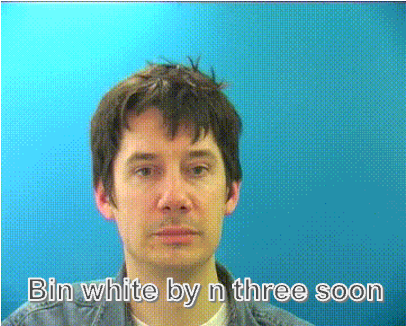
  
- <span style="font-family:times; font-size:1.3em;">Speaker 23

  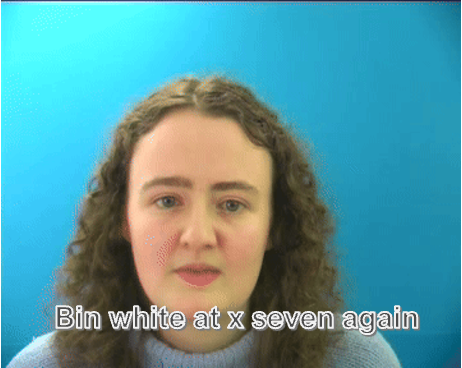
  

Explanation:

- <span style="font-family:times; font-size:1.3em;"><b>Specify Paths:</b> Defines the paths to the test video and alignment files.
- <span style="font-family:times; font-size:1.3em;"><b>Load and Preprocess Data:</b> Uses the load_video and load_alignments functions to preprocess the video frames and alignment data.
- <span style="font-family:times; font-size:1.3em;"><b>Ensure Batch Dimension:</b> Adds a batch dimension to the frames if necessary.
- <span style="font-family:times; font-size:1.3em;"><b>Make Predictions: </b>Uses the model to predict character probabilities for the frames.
- <span style="font-family:times; font-size:1.3em;"><b>Decode Predictions:</b> Applies CTC decoding to convert the predictions to text.
- <span style="font-family:times; font-size:1.3em;"><b>Convert to Text:</b> Converts the decoded predictions and actual alignments from numerical indices to text.
- <span style="font-family:times; font-size:1.3em;"><b>Display Results:</b> Prints the actual and predicted texts for comparison.
    

In [54]:
#_______________________________________________________________________TEST_PERFORMED_ON_CUSTOM_DATASET_ Speaker-01_______________________________________________________
# Specify paths
video_path = 'data/s1/bwbn3s.mpg'
alignment_path = 'data/alignments/s1/bwbn3s.align'

# Load and preprocess the video and alignments
frames = load_video(video_path)
alignments = load_alignments(alignment_path)

# Ensure frames have a batch dimension
if len(frames.shape) == 4:
    frames = tf.expand_dims(frames, axis=0)

# Make predictions
predictions = model.predict(frames)

# Decode predictions
decoded_predictions = tf.keras.backend.ctc_decode(predictions, input_length=[frames.shape[1]] * frames.shape[0], greedy=True)[0][0]

# Convert predictions and actual indices to text
predicted_text = tf.strings.reduce_join(numbers_to_letters(decoded_predictions), separator='').numpy().decode('utf-8')
actual_text = tf.strings.reduce_join(numbers_to_letters(alignments), separator='').numpy().decode('utf-8')

# Display results
print('Actual Text:', actual_text)
print('Predicted Text:', predicted_text)

1/1 [==============================] - 2s 2s/step
Actual Text:  bin white by n three soon
Predicted Text:  lay white by s tw soon


In [48]:
#_______________________________________________________________________TEST_PERFORMED_ON_CUSTOM_DATASET_Speaker-23_______________________________________________________

# Specify paths
video_path = 'data/test/s23/bbac1s.mpg'
alignment_path = 'data/test/align/bbac1s.align'

# Load and preprocess the video and alignments
frames = load_video(video_path)
alignments = load_alignments(alignment_path)

# Ensure frames have a batch dimension
if len(frames.shape) == 4:
    frames = tf.expand_dims(frames, axis=0)

# Make predictions
predictions = model.predict(frames)

# Decode predictions
decoded_predictions = tf.keras.backend.ctc_decode(predictions, input_length=[frames.shape[1]] * frames.shape[0], greedy=True)[0][0]

# Convert predictions and actual indices to text
predicted_text = tf.strings.reduce_join(numbers_to_letters(decoded_predictions), separator='').numpy().decode('utf-8')
actual_text = tf.strings.reduce_join(numbers_to_letters(alignments), separator='').numpy().decode('utf-8')

# Display results
print('Actual Text:', actual_text)
print('Predicted Text:', predicted_text)

1/1 [==============================] - 2s 2s/step
Actual Text:  bin blue at c one soon
Predicted Text:  bin blue it o ene soon


### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'>Testing the Model and Calculating Similarity
<span style="font-family:times; font-size:1.3em;"> This section tests the trained model on a custom dataset, decodes the predictions, and calculates a custom similarity score between the actual and predicted texts.

In [51]:
def calculate_similarity(actual, predicted):
    matches = sum(1 for ac, pr in zip(actual, predicted) if ac == pr)
    max_len = max(len(actual), len(predicted))
    return matches / max_len if max_len > 0 else 0

# Rest of your code setup for predictions

# Specify paths
video_path = 'data/s1/bwbn3s.mpg'
alignment_path = 'data/alignments/s1/bwbn3s.align'

# Load and preprocess the video and alignments
frames = load_video(video_path)
alignments = load_alignments(alignment_path)

# Ensure frames have a batch dimension
if len(frames.shape) == 4:
    frames = tf.expand_dims(frames, axis=0)

# Make predictions
predictions = model.predict(frames)

# Decode predictions
decoded_predictions = tf.keras.backend.ctc_decode(predictions, input_length=[frames.shape[1]] * frames.shape[0], greedy=True)[0][0]

# Convert predictions and actual indices to text
predicted_text = tf.strings.reduce_join(numbers_to_letters(decoded_predictions), separator='').numpy().decode('utf-8')
actual_text = tf.strings.reduce_join(numbers_to_letters(alignments), separator='').numpy().decode('utf-8')

# Display results
print('Actual Text:', actual_text)
print('Predicted Text:', predicted_text)

# Calculate custom similarity score
similarity = calculate_similarity(actual_text, predicted_text)
print('Custom Similarity Score:', similarity)

1/1 [==============================] - 2s 2s/step
Actual Text:  bin white by n three soon
Predicted Text:  lay white by s tw soon
Custom Similarity Score: 0.5


In [49]:
def calculate_similarity(actual, predicted):
    matches = sum(1 for ac, pr in zip(actual, predicted) if ac == pr)
    max_len = max(len(actual), len(predicted))
    return matches / max_len if max_len > 0 else 0

# Rest of your code setup for predictions

# Specify paths
video_path = 'data/test/s23/bwax7a.mpg'
alignment_path = 'data/test/align/bwax7a.align'

# Load and preprocess the video and alignments
frames = load_video(video_path)
alignments = load_alignments(alignment_path)

# Ensure frames have a batch dimension
if len(frames.shape) == 4:
    frames = tf.expand_dims(frames, axis=0)

# Make predictions
predictions = model.predict(frames)

# Decode predictions
decoded_predictions = tf.keras.backend.ctc_decode(predictions, input_length=[frames.shape[1]] * frames.shape[0], greedy=True)[0][0]

# Convert predictions and actual indices to text
predicted_text = tf.strings.reduce_join(numbers_to_letters(decoded_predictions), separator='').numpy().decode('utf-8')
actual_text = tf.strings.reduce_join(numbers_to_letters(alignments), separator='').numpy().decode('utf-8')

# Display results
print('Actual Text:', actual_text)
print('Predicted Text:', predicted_text)

# Calculate custom similarity score
similarity = calculate_similarity(actual_text, predicted_text)
print('Custom Similarity Score:', similarity)

1/1 [==============================] - 2s 2s/step
Actual Text:  bin white at x seven again
Predicted Text:  bin white at k seven again
Custom Similarity Score: 0.9629629629629629


### <span style="font-family:times; font-size:1.3em;"> <span style='color:orange'>Batch Processing of Test Videos and Calculation of Average Similarity Score.
<span style="font-family:times; font-size:1.3em;"> This code processes a directory of test videos and their corresponding alignment files. It calculates the similarity score for each video and computes the average similarity score across all processed videos.

In [50]:
import os
import tensorflow as tf
import numpy as np

def calculate_similarity(actual, predicted):
    matches = sum(1 for ac, pr in zip(actual, predicted) if ac == pr)
    max_len = max(len(actual), len(predicted))
    return matches / max_len if max_len > 0 else 0

def process_video_and_alignment(video_path, alignment_path):
    # Load and preprocess the video and alignments
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    # Ensure frames have a batch dimension
    if len(frames.shape) == 4:
        frames = tf.expand_dims(frames, axis=0)

    # Make predictions
    predictions = model.predict(frames)

    # Decode predictions
    decoded_predictions = tf.keras.backend.ctc_decode(predictions, input_length=[frames.shape[1]] * frames.shape[0], greedy=True)[0][0]

    # Convert predictions and actual indices to text
    predicted_text = tf.strings.reduce_join(numbers_to_letters(decoded_predictions), separator='').numpy().decode('utf-8')
    actual_text = tf.strings.reduce_join(numbers_to_letters(alignments), separator='').numpy().decode('utf-8')

    # Calculate custom similarity score
    return calculate_similarity(actual_text, predicted_text)

# Paths to the directories containing test videos and alignment files
video_dir = 'data/test/s23'
align_dir = 'data/test/align'

# Loop over the video files in the video directory
similarity_scores = []
for video_file in os.listdir(video_dir):
    if video_file.endswith(".mpg"):
        base_name = os.path.splitext(video_file)[0]
        video_path = os.path.join(video_dir, video_file)
        alignment_path = os.path.join(align_dir, base_name + '.align')

        # Check if the corresponding alignment file exists
        if os.path.exists(alignment_path):
            similarity_score = process_video_and_alignment(video_path, alignment_path)
            similarity_scores.append(similarity_score)

# Calculate average similarity over all processed videos
if similarity_scores:
    average_similarity = sum(similarity_scores) / len(similarity_scores)
    print(f'Average Similarity Score: {average_similarity}')
else:
    print('No videos were processed.')

1/1 [==============================] - 2s 2s/step
Average Similarity Score: 0.7732019228046219


# Average Similarity Score: 0.7732019228046219